<a href="https://colab.research.google.com/github/carloslme/handson-ml2-book/blob/main/08_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introduction
Reducing dimensionality does cause some information loss (just like compressing an image to JPEG can degrade its quality), so even though it will speed up training, it may make your system perform slightly worse. It also makes your pipelines a bit more complex and thus harder to maintain. So, **if training is too slow, you should first try to train your system with the original data before considering using dimensionality reduction**. In some cases, reducing the dimensionality of the training data may filter out some noise and unnecessary details and thus result in higher performance, but in general it won’t; it will just speed up training.

Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of a high-dimensional training set on a graph and often gain some important insights by visually detecting patterns, such as clusters.

# The curse of dimensionality

High-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other. This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, **the more dimensions the training set has, the greater the risk of overfitting it**.


# Projection methods

In most real-world problems, training instances are not spread out uniformly across all dimensions.

Reducing the dimensionality of your training set before training a model will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.

In [ ]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# PCA using SVD decomposition

First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

The projection onto the solid line preserves the maximum variance, while the projection onto the dotted line preserves very little variance and the projection onto the dashed line preserves an intermediate amount of variance.

In short, PCA identifies the axis that accounts for the largest amount of variance in the training set.

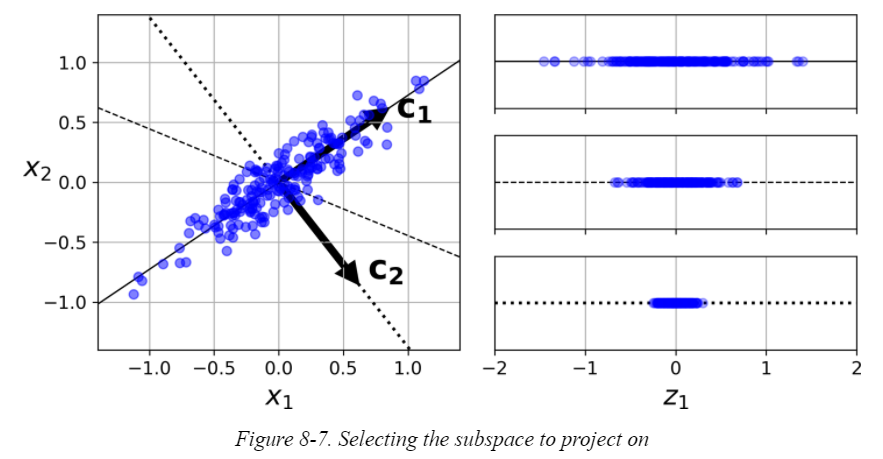

It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. This is the rather simple idea behind PCA.

**NOTE**

For each principal component, PCA finds a zero-centered unit vector pointing in the direction of the PC. Since two opposing unit vectors lie on the same axis, the direction of the unit vectors returned by PCA is not stable: if you perturb the training set slightly and run PCA again, the unit vectors may point in the opposite direction as the original vectors. However, they will generally still lie on the same axes. In some cases, a pair of unit vectors may even rotate or swap (if the variances along these two axes are close), but the plane they define will generally remain the same.


To find the principal components of a training set there is a standard matriz factorization technique called Singular Value Decomposition (SVD) that can decompose the training set matrix $X$ into a matrix multiplication of three matrices $U Σ V^{⊺}$ , where $V$ contains the unit vectors that define all the principal components that we are looking for.

**WARNING**

PCA assumes that the dataset is centered around the origin. If you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t forget to center the data first.

In [ ]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [ ]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [ ]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to d dimensions by projecting it onto the hyperplane defined by the first d principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.



In [ ]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [ ]:
X2D_using_svd = X2D

# PCA using Scikit-Learn
Scikit-Learn automatically takes care of centering the data.


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [ ]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [ ]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

The PCA object gives access to the principal components that it computed:

In [ ]:
pca.components_


array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [ ]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [ ]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

This output tell us that the 84.2% of the dataset's variance lies along the first PC, and 14.6% lies along the second PC. This leaves less than 1.2% for the third PC, so it is reasonable to assume that the third PC probably carries little information.

#Choosing the right number of dimensions
It is simple just to choose the number of dimensions that add up to a sufficiently large portion of the variance, like 95%. Unless, of course, you are reducing dimensionality for data visualization—in that case you will want to reduce the dimensionality down to 2 or 3.

Next code performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set's variance.

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
mnist.target = mnist.target.astype(np.uint8)

ValueError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [ ]:
d

Elbow plot of the explained variance as a function of the number of dimensions. In this case, reducing the dimensionality down to about 100 dimensions wouldn't lose too much explained variance. 

In [ ]:

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

Explained variance as a function of the number of dimensions.

# PCA for compression
For this example, after applying PCA to the MNIST dataset while preserving 95% of its variance, the dataset is now less than 20% of its original size. The reduction was from 784 features to 150. 

This reduction size can speed up a classification algorithm (SVM) tremendously.

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

In [ ]:
np.sum(pca.explained_variance_ratio_)

It is possible to decompress the reduced dataset back to the 784 original dimensions by applying the inverse transformation of the PCA projection. Although it will not give you back the original data, since the projection lost within 5% variance, it will likely be close to the original data. 

The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the *reconstruction error*.

In [ ]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [ ]:
X_reduced_pca = X_reduced

In [ ]:
X_reduced_pca

# Randomized PCA
Using the `svd_solver` hyperparameter to "`randomized`", Scikit-Learn uses a stochastic algorithm called Randomized PCA that quickly finds an approximation of the first $d$ principal components.

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# Incremental PCA
Incremental PCA (IPCA) allows you to split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive).

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [ ]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

#### Using memmap()

In [ ]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [ ]:
del X_mm

In [ ]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# PCA Kernel
In Chapter 5 we discussed the kernel trick, a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinear classification and regression with Support Vector Machines. Recall that a linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the original space. 


It turns out that **the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction**. This is called Kernel PCA (kPCA). It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

In [4]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [8]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


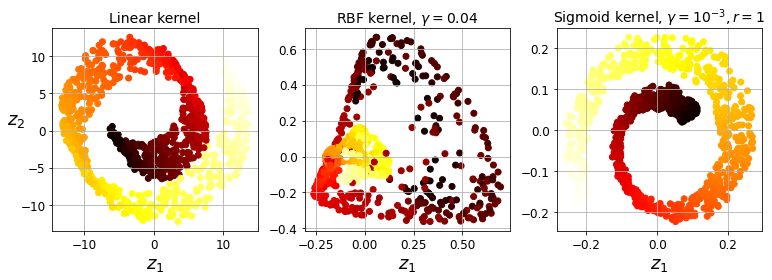

In [9]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

# Selecting a Kernel and Tuning Hyperparameters
There is no obvious performance measure to help you select the best kernel and hyperparameter values. Dimensionality reduction is often a preparation step for supervised learning task (e.g. classification), so you can use grid search to select the kernel and hyperparameters that lead to the best performance on that task.

Next code creates a two-step pipeline, fir reducing dimensionality to two dimendiones using kPCA, then applying Logistic Regression dor classification. Then it uses GridSearchCV to find the best kernel and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline:

In [10]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

In [11]:
param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

In [12]:
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [13]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [14]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [15]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766125